<a href="https://colab.research.google.com/github/zwimpee/cursivetransformer/blob/main/cursivetransformer_mech_interp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setup

!pip install git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python
!pip install transformer_lens
!pip install gradio
!pip install wandb
!pip install einops
!pip install matplotlib
!pip install datasets

# Clone the cursivetransformer repository and install its requirements
!rm -rf cursivetransformer && git clone https://github.com/zwimpee/cursivetransformer.git
!pip install -r cursivetransformer/requirements.txt

  Cloning https://github.com/callummcdougall/CircuitsVis.git to /tmp/pip-req-build-a0hj2_ye
  Running command git clone --filter=blob:none --quiet https://github.com/callummcdougall/CircuitsVis.git /tmp/pip-req-build-a0hj2_ye
  Resolved https://github.com/callummcdougall/CircuitsVis.git to commit 1e6129d08cae7af9242d9ab5d3ed322dd44b4dd3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for circuitsvis: filename=circuitsvis-0.0.0-py3-none-any.whl size=6172334 sha256=59415c32edc93016c6c42f3b4833706a3be43b700e7573be5495cc7c0ec5f306
  Stored in directory: /tmp/pip-ephem-wheel-cache-5st4ukw0/wheels/86/be/ad/78078aba9344d200aad61b63d35cdaecdec160212f039eed74
Successfully built circuitsvis
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib_metadata 8.4.0
    Uninstalling importlib_metadata-8.4.0:
      Successfully uninstalled importlib_metadata-8.4.0
ERROR: 

In [8]:
import os
import sys; sys.path.append('/content/cursivetransformer');
import copy
import types
from typing import List, Callable, Dict, Optional, Union, Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import einops
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import circuitsvis as cv
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from jaxtyping import Float, Int

from cursivetransformer.model import get_all_args, get_checkpoint, get_latest_checkpoint_artifact
from cursivetransformer.data import create_datasets, offsets_to_strokes, strokes_to_offsets
from cursivetransformer.sample import generate, generate_n_words, plot_strokes
from cursivetransformer.mech_interp import (
    HookedCursiveTransformer,
    HookedCursiveTransformerConfig,
    convert_cursivetransformer_model_config,
    visualize_attention
)

import transformer_lens.utils as utils
from transformer_lens.hook_points import HookPoint
from transformer_lens import ActivationCache

torch.set_grad_enabled(False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import wandb
wandb.login()

True

In [3]:
args = get_all_args(False)
args.sample_only = True
args.load_from_run_id = '6le6tujz'
args.wandb_entity = 'sam-greydanus'
args.dataset_name = 'bigbank'
args.wandb_run_name = 'cursivetransformer_dictionary_learning'

torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

train_dataset, test_dataset = create_datasets(args)

args.block_size = train_dataset.get_stroke_seq_length()
args.context_block_size = train_dataset.get_text_seq_length()
args.vocab_size = train_dataset.get_vocab_size()
args.context_vocab_size = train_dataset.get_char_vocab_size()

Trying to load dataset file from /content/cursivetransformer/data/bigbank.json.zip
Succeeded in loading the bigbank dataset; contains 1900 items.
For a dataset of 1805 examples we can generate 440811596555 combinations of 4 examples.
Generating 497000 4-word examples.
For a dataset of 95 examples we can generate 3183545 combinations of 4 examples.
Generating 3000 4-word examples.
Number of examples in the train dataset: 497000
Number of examples in the test dataset: 3000
Max token sequence length: 1000
Number of unique characters in the ascii vocabulary: 71
Ascii vocabulary:
	" enaitoshrdx.vpukbgfcymzw1lqj804I92637OTAS5N)EHR"'(BCQLMWYU,ZF!DXV?KPGJ"
Split up the dataset into 497000 training examples and 3000 test examples


In [4]:
cfg = convert_cursivetransformer_model_config(args)
model = HookedCursiveTransformer.from_pretrained("cursivetransformer", cfg)

Loading pretrained model cursivetransformer
Finding latest checkpoint for W&B run id 6le6tujz
  model:best_checkpoint:v70
  model:best_checkpoint:v71
  model:best_checkpoint:v72
  model:best_checkpoint:v73
  model:best_checkpoint:v74
  model:best_checkpoint:v75
  model:best_checkpoint:v76
  model:best_checkpoint:v77
  model:best_checkpoint:v78
  model:best_checkpoint:v79
  model:best_checkpoint:v80
  model:best_checkpoint:v81
  model:best_checkpoint:v82
  model:best_checkpoint:v83
  model:best_checkpoint:v84
  model:best_checkpoint:v85
  model:best_checkpoint:v86
  model:best_checkpoint:v87
  model:best_checkpoint:v88
  model:best_checkpoint:v89
  wandb-history:run-6le6tujz-history:v4
Selected:  model:best_checkpoint:v89


wandb:   1 of 1 files downloaded.  


Successfully loaded pretrained model cursivetransformer


# Induction Circuit Investigation and Analysis





In [15]:
def generate_repeated_stroke_tokens(
    model,
    seq_len: int,
    n_repeats: int,
    batch_size: int = 1
) -> Int[torch.Tensor, "batch_size full_seq_len"]:
    """
    Generates a sequence of repeated stroke tokens, alternating between θ and r tokens.

    Args:
        model: The model instance.
        seq_len: Number of (θ, r) pairs in the initial sequence.
        n_repeats: Number of times to repeat the sequence.
        batch_size: Batch size.

    Returns:
        rep_tokens: Tensor of shape [batch_size, n_repeats * 2 * seq_len]
    """
    device = model.cfg.device
    feature_sizes = test_dataset.feature_sizes  # [size_r_bins, size_theta_bins]
    cumulative_sizes = test_dataset.cumulative_sizes  # cumulative indices for token types

    # Get valid indices for θ and r tokens
    theta_token_indices = torch.arange(
        cumulative_sizes[1],
        cumulative_sizes[2],
        device=device
    )
    r_token_indices = torch.arange(
        cumulative_sizes[0],
        cumulative_sizes[1],
        device=device
    )

    # Generate random θ and r tokens
    random_theta_tokens = theta_token_indices[
        torch.randint(
            low=0,
            high=feature_sizes[1],
            size=(batch_size, seq_len),
            device=device
        )
    ]
    random_r_tokens = r_token_indices[
        torch.randint(
            low=0,
            high=feature_sizes[0],
            size=(batch_size, seq_len),
            device=device
        )
    ]

    # Alternate between θ and r tokens
    stroke_tokens_half = torch.zeros(batch_size, seq_len * 2, dtype=torch.long, device=device)
    stroke_tokens_half[:, 0::2] = random_theta_tokens
    stroke_tokens_half[:, 1::2] = random_r_tokens

    # Repeat the sequence
    rep_tokens = stroke_tokens_half.repeat(1, n_repeats)

    return rep_tokens

def generate_random_ascii_context(
    model,
    batch_size: int = 1
) -> Int[torch.Tensor, "batch_size context_seq_len"]:
    """
    Generates a random ASCII context sequence.

    Args:
        model: The model instance.
        batch_size: Batch size.

    Returns:
        context_tokens: Tensor of shape [batch_size, context_seq_len]
    """
    device = model.cfg.device
    context_seq_len = model.cfg.context_block_size
    context_vocab_size = model.cfg.context_vocab_size

    context_tokens = torch.randint(
        low=0,
        high=context_vocab_size - 1,  # Exclude PAD token
        size=(batch_size, context_seq_len),
        dtype=torch.long,
        device=device
    )

    return context_tokens

In [32]:
def run_and_cache_model_repeated_tokens(
    model,
    rep_tokens: torch.Tensor,
    context_tokens: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor, ActivationCache]:
    """
    Runs the model on repeated tokens and caches activations.

    Args:
        model: The model instance.
        rep_tokens: Input stroke tokens of shape [batch_size, seq_len]
        context_tokens: Input context tokens of shape [batch_size, context_seq_len]

    Returns:
        logits: Model output logits.
        cache: Activation cache.
    """
    # Shift inputs to create targets
    inputs = rep_tokens[:, :-1]
    targets = rep_tokens[:, 1:]

    # Run model with cache
    logits, cache = model.run_with_cache(
        tokens=inputs,
        context=context_tokens,
        targets=targets,
        return_type="both"
    )

    return logits, targets, cache

In [33]:
# - [ ] TODO: Validate this logic, including the definition of the metric we are calling "induction score"
def compute_induction_scores(
    model,
    rep_tokens: torch.Tensor,
    cache: ActivationCache
) -> torch.Tensor:
    """
    Computes induction scores for all attention heads, accounting for the alternating tokens.

    Args:
        model: The model instance.
        rep_tokens: Input stroke tokens of shape [batch_size, seq_len]
        cache: Activation cache.

    Returns:
        induction_scores: Tensor of shape [num_layers, num_heads]
    """
    num_layers = model.cfg.n_layers
    num_heads = model.cfg.n_heads
    induction_scores = torch.zeros(num_layers, num_heads, device=model.cfg.device)

    batch_size, seq_len = rep_tokens.shape

    # Group tokens into pairs of (θ, r)
    token_pairs = rep_tokens.view(batch_size, seq_len // 2, 2)  # Shape: [batch_size, seq_len_pairs, 2]

    # Represent token pairs as tuples for comparison
    token_pair_tuples = [tuple(pair.tolist()) for pair in token_pairs[0]]

    # For each position in the second half, find matching token in the first half
    half_point = len(token_pair_tuples) // 2
    for layer in range(num_layers):
        attn_patterns = cache["pattern", layer]  # Shape: [batch_size, num_heads, seq_len_q, seq_len_k]
        for head in range(num_heads):
            attn = attn_patterns[0, head]  # Shape: [seq_len_q, seq_len_k]
            scores = []
            for i in range(half_point, len(token_pair_tuples) - 1):
                current_pair = token_pair_tuples[i]
                # Find the last occurrence of the same token pair before position i
                try:
                    k_pos = max(j for j in range(i) if token_pair_tuples[j] == current_pair)
                    # Since each token pair corresponds to 2 tokens, adjust positions
                    q_pos = i * 2  # Query position in token indices
                    k_pos = k_pos * 2  # Key position in token indices
                    # Get attention weight from q_pos to k_pos (for both θ and r tokens)
                    attn_weight_theta = attn[q_pos - 1, k_pos - 1]
                    attn_weight_r = attn[q_pos, k_pos]
                    # Average the attention weights for θ and r tokens
                    attn_weight = (attn_weight_theta + attn_weight_r) / 2
                    scores.append(attn_weight.item())
                except ValueError:
                    # No previous matching token pair found
                    continue
            if scores:
                induction_scores[layer, head] = torch.tensor(scores).mean()
    return induction_scores

In [34]:
def plot_induction_scores(induction_scores: torch.Tensor):
    """
    Plots a heatmap of induction scores.

    Args:
        induction_scores: Tensor of shape [num_layers, num_heads]
    """
    plt.figure(figsize=(12, 6))
    sns.heatmap(
        induction_scores.cpu().numpy(),
        annot=True,
        fmt=".2f",
        cmap="YlGnBu",
        xticklabels=[f"H{h}" for h in range(induction_scores.shape[1])],
        yticklabels=[f"L{l}" for l in range(induction_scores.shape[0])]
    )
    plt.title("Induction Scores per Head")
    plt.xlabel("Heads")
    plt.ylabel("Layers")
    plt.show()

In [35]:
def plot_head_attention_pattern(
    cache: ActivationCache,
    layer: int,
    head: int,
    seq_len: int
):
    """
    Plots the attention pattern of a specific head.

    Args:
        cache: Activation cache.
        layer: Layer index.
        head: Head index.
        seq_len: Total sequence length.
    """
    attn = cache["pattern", layer][0, head].detach().cpu().numpy()
    plt.figure(figsize=(8, 6))
    plt.imshow(attn, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title(f"Attention Pattern - Layer {layer}, Head {head}")
    plt.xlabel("Key Positions")
    plt.ylabel("Query Positions")
    plt.show()

In [36]:
def compute_cross_attention_induction_scores(
    model,
    context_tokens: torch.Tensor,
    cache: ActivationCache
) -> torch.Tensor:
    """
    Computes induction-like scores for cross-attention heads.

    Args:
        model: The model instance.
        context_tokens: Context tokens of shape [batch_size, context_seq_len]
        cache: Activation cache.

    Returns:
        cross_induction_scores: Tensor of shape [num_layers, num_heads]
    """
    num_layers = model.cfg.n_layers
    num_heads = model.cfg.n_heads
    cross_induction_scores = torch.zeros(num_layers, num_heads, device=model.cfg.device)

    batch_size, context_seq_len = context_tokens.shape

    for layer in range(num_layers):
        attn_patterns = cache["pattern", layer, "cross_attn"]  # Need to access cross-attention patterns
        for head in range(num_heads):
            attn = attn_patterns[0, head]  # Shape: [stroke_seq_len, context_seq_len]
            # For this example, we might need more specific analysis based on the use case
            # Placeholder for cross-attention induction score computation
            cross_induction_scores[layer, head] = attn.mean().item()
    return cross_induction_scores

In [37]:
# - [ ] TODO: Test for induction heads and analyze results
# Parameters
seq_len = 50  # Number of (θ, r) pairs in the initial sequence
n_repeats = 2  # Number of repetitions
batch_size = 1

# Generate repeated stroke tokens and random ASCII context
rep_tokens = generate_repeated_stroke_tokens(model, seq_len, n_repeats, batch_size)
context_tokens = generate_random_ascii_context(model, batch_size)

In [38]:
# Run the model and cache activations
model = model.to(device)
logits, targets, cache = run_and_cache_model_repeated_tokens(model, rep_tokens.to(device), context_tokens.to(device))

Moving model to device:  cuda


In [39]:
# Compute induction scores for self-attention heads
induction_scores = compute_induction_scores(model, rep_tokens, cache)

# Compute induction-like scores for cross-attention heads
cross_induction_scores = compute_cross_attention_induction_scores(model, context_tokens, cache)

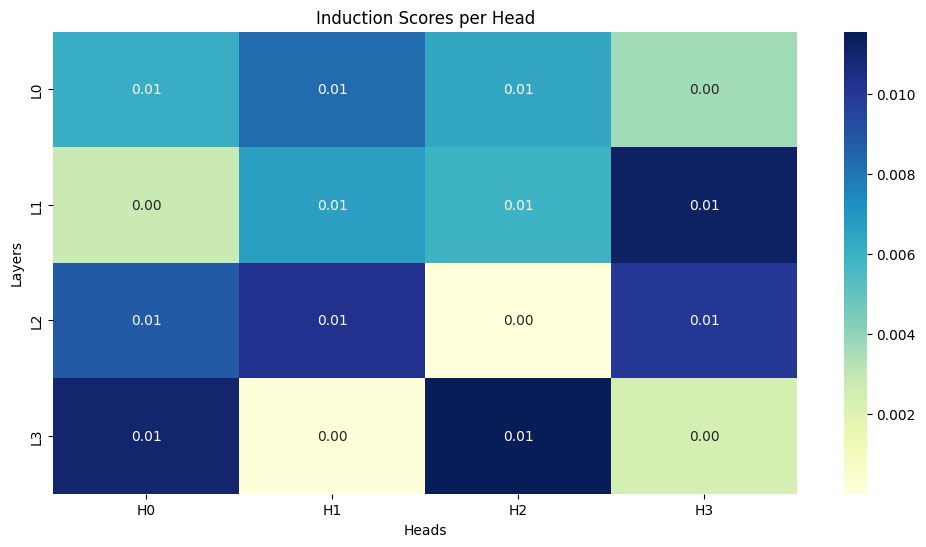

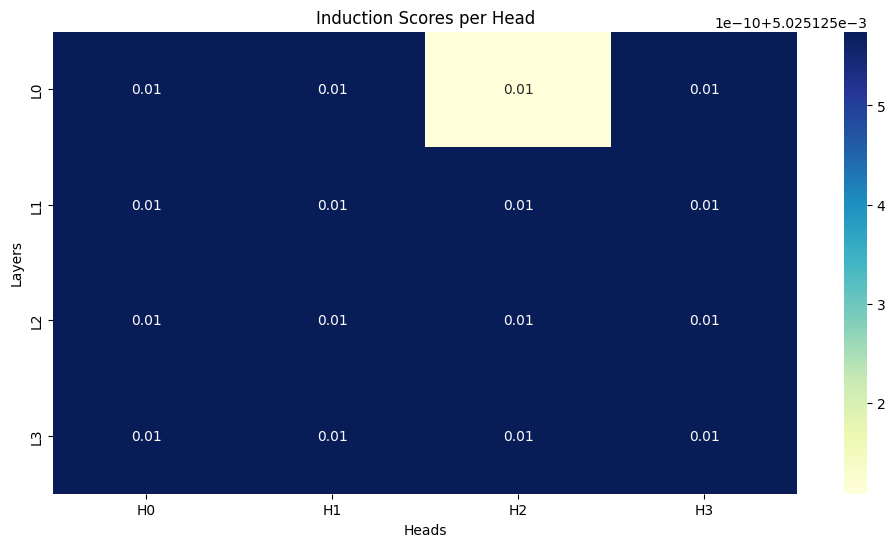

In [40]:
# Plot induction scores for self-attention heads
plot_induction_scores(induction_scores)

# Plot induction-like scores for cross-attention heads
plot_induction_scores(cross_induction_scores)

Layer 3, Head 2, Induction Score: 0.0115


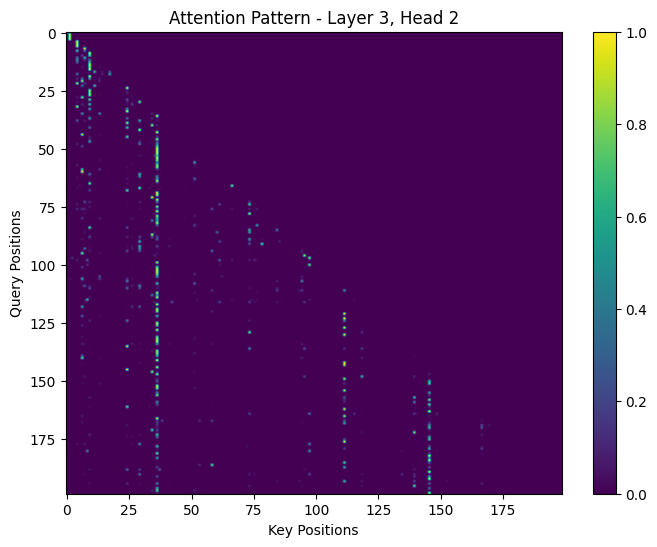

Layer 1, Head 3, Induction Score: 0.0113


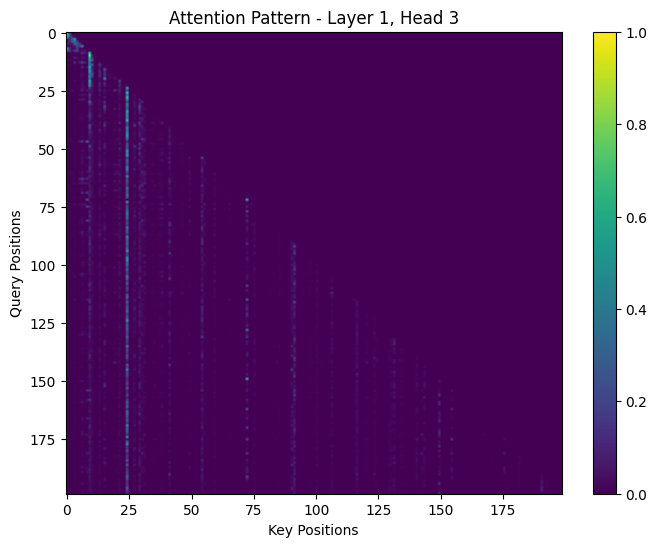

Layer 3, Head 0, Induction Score: 0.0110


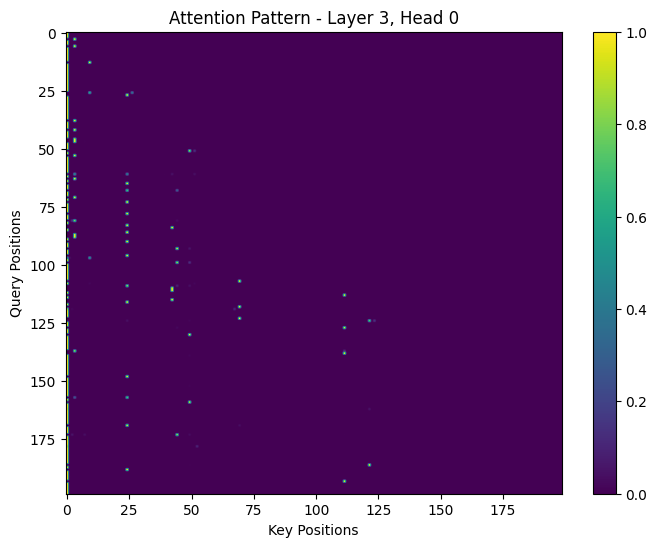

Layer 2, Head 1, Induction Score: 0.0103


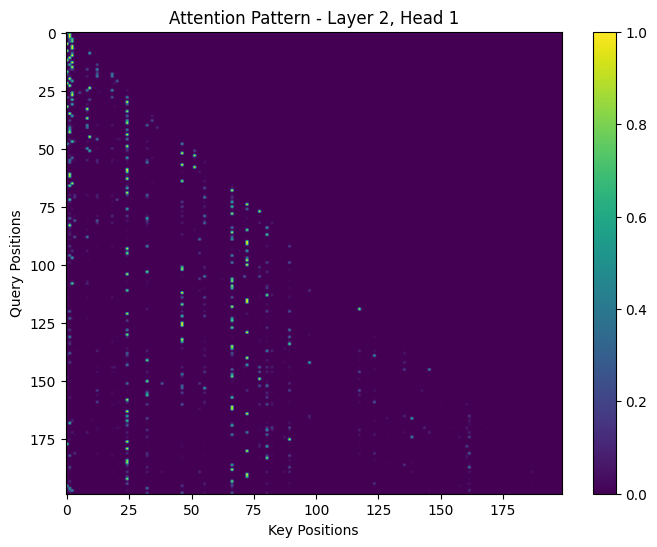

Layer 2, Head 3, Induction Score: 0.0100


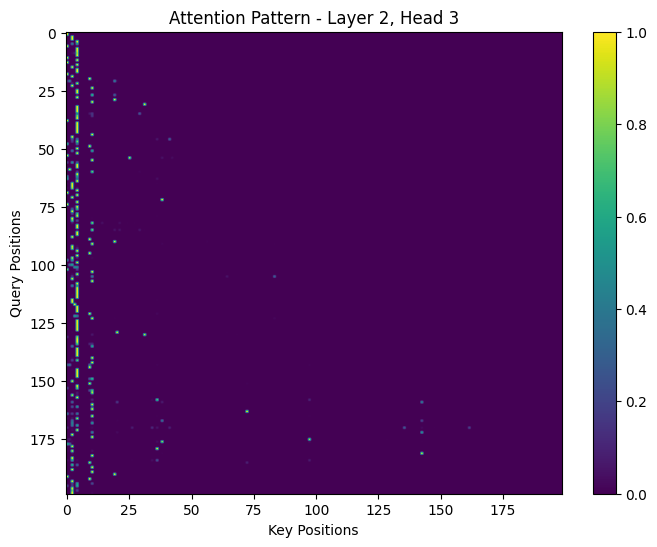

In [41]:
# Identify top N heads with highest induction scores
N = 5
induction_scores_flat = induction_scores.view(-1)
top_scores, top_indices = torch.topk(induction_scores_flat, N)
num_heads = model.cfg.n_heads

for idx in top_indices:
    layer = idx // num_heads
    head = idx % num_heads
    print(f"Layer {layer}, Head {head}, Induction Score: {induction_scores[layer, head]:.4f}")
    # Plot attention pattern
    plot_head_attention_pattern(cache, layer, head, seq_len * n_repeats * 2)

In [ ]:
# - [ ] TODO: Debug and validate results

# Activation Patching

In [ ]:
# - [ ] TODO: Implement Activation Patching